## Monte Carlo Blackjack

In [1]:
import gym
import sys
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [7]:
for i_episode in range(5):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print("End game! Reward: ",reward)
            print('You won :)\n') if reward > 0 else print("You lose :(\n")
            break

(7, 5, False)
(15, 5, False)
End game! Reward:  -1.0
You lose :(

(13, 6, False)
End game! Reward:  -1.0
You lose :(

(9, 3, False)
End game! Reward:  1.0
You won :)

(21, 8, True)
End game! Reward:  0.0
You lose :(

(16, 10, False)
(20, 10, False)
End game! Reward:  0.0
You lose :(



## Part 1 : Monte Carlo Prediction

In [10]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [11]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((18, 4, False), 0, -1.0)]
[((13, 6, False), 1, -1.0)]
[((10, 3, False), 1, 0.0), ((16, 3, False), 1, -1.0)]


In [12]:
env?

Type:        BlackjackEnv
String form: <BlackjackEnv<Blackjack-v0>>
File:        c:\users\gusti\appdata\local\programs\python\python37\lib\site-packages\gym\envs\toy_text\blackjack.py
Docstring:  
Simple blackjack environment

Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.
Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).
The game starts with dealer having one face up and one face down card, while
player having two face up cards. (Virtually for all Blackjack games today).

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.

If neither player no

In [17]:
sys.stdout.flush?

Signature: sys.stdout.flush()
Docstring:
trigger actual zmq send

send will happen in the background thread
File:      c:\users\gusti\appdata\local\programs\python\python37\lib\site-packages\ipykernel\iostream.py
Type:      method


In [19]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # Initialize empty dictionaries of arrays
    return_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes),end="")
            sys.stdout.flush()
        ## Todo
        ## Generate episode
        episode = generate_episode(env)
        ## obtain states, actions and reward
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        ## Iteration through episode
        for i, state in enumerate(states):
            return_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1
            Q[state][actions[i]] = return_sum[state][actions[i]] / N[state][actions[i]] 
    return Q

Episode 500000/500000.

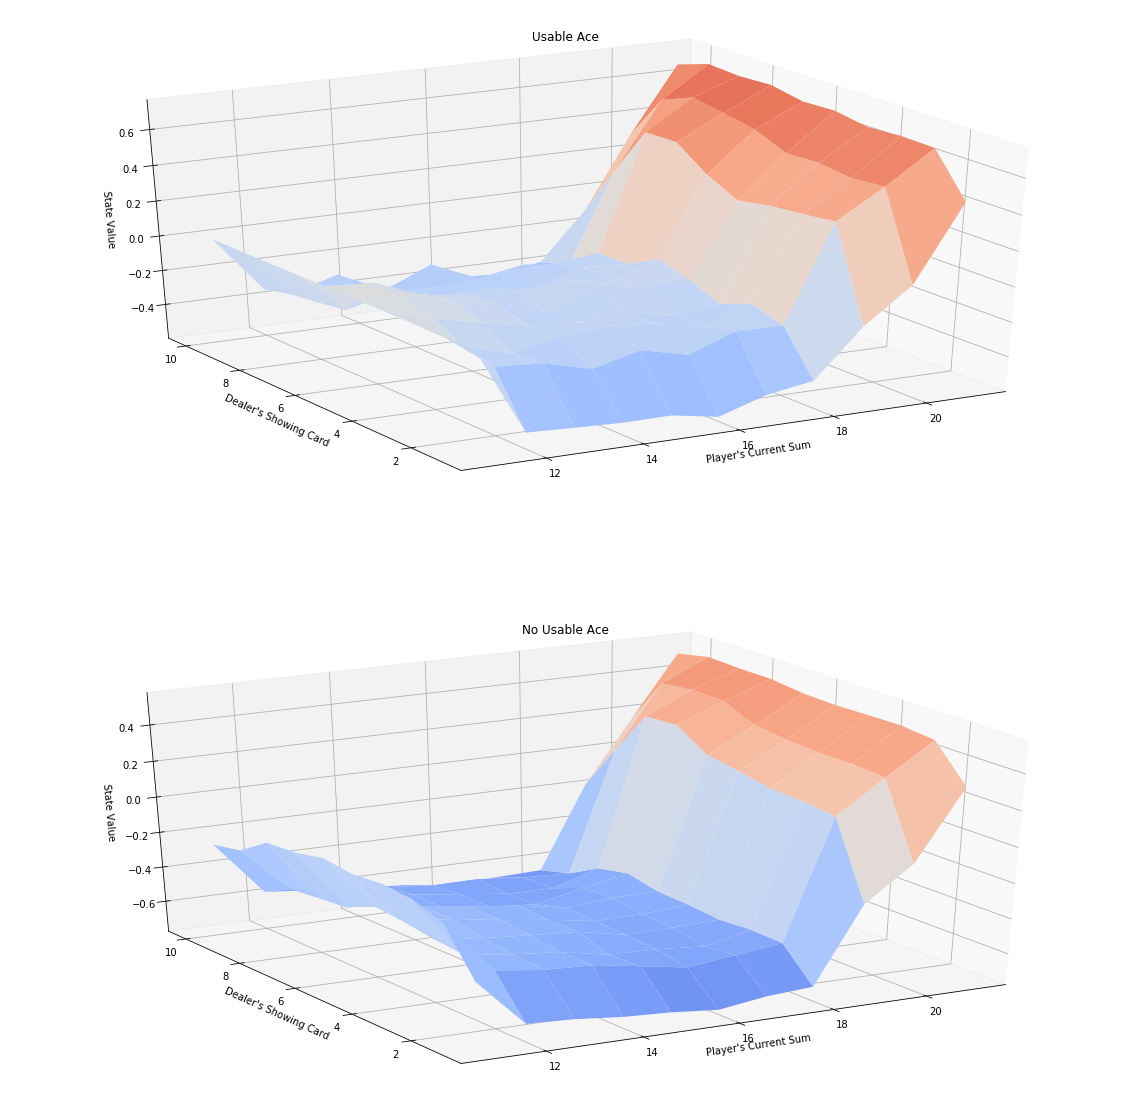

In [20]:
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) for k, v in Q.items())

plot_blackjack_values(V_to_plot)